In [5]:
import numpy as np
import torch
from library.GCN import *
from pathlib import Path
from torch.utils.data import DataLoader,SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
import itertools

Test $R^2$, MAE and RMSE of each outer fold

In [6]:
#### Inputs
max_atoms = 30 # fixed value
node_vec_len = 16 # fixed value
batch_size = 256
hidden_nodes = 128
n_conv_layers = 4
n_hidden_layers = 2
learning_rate = 0.003
n_epochs = 50
use_GPU = False

model = ChemGCN(node_vec_len=node_vec_len,
                node_fea_len=hidden_nodes,
                hidden_fea_len=hidden_nodes,
                n_conv=n_conv_layers,
                n_hidden=n_hidden_layers,
                n_outputs=1,
                p_dropout=0.1)

#### Start by creating dataset
main_path = Path.cwd().parents[0]
data_path = main_path / "data" / "RDKit" / "rdkit_only_valid_smiles_qm9.pkl"
dataset = GraphData(dataset_path=data_path, max_atoms=max_atoms, 
                        node_vec_len=node_vec_len)

state_dict = torch.load(
    main_path / 'data' / 'GCN' / 'GCN_outer_fold_weights' / 'GCN_weight_outer_fold_0.pth',
    map_location='cpu'
)

model.load_state_dict(state_dict)

dataset_indices = np.arange(0, len(dataset), 1)

#### Split data into training and test sets

y = np.array([float(dataset[i][1]) for i in range(len(dataset))])

num_bins = 10
gap_bins_outer = pd.qcut(y, q=num_bins, labels=False)

outer_seed = 42
inner_seed = 123

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=outer_seed)

temp = outer_cv.split(dataset_indices, gap_bins_outer)
outer_fold_splits = [x for x in temp]

mae_outer_folds = []
loss_outer_folds = []
r2_outer_folds = []
targets_outer_folds = []
predictions_outer_folds = []

for outer_fold_idx in range(5):
    train_val_idx = outer_fold_splits[outer_fold_idx][0]
    test_idx = outer_fold_splits[outer_fold_idx][1]

    # Create dataloader
    test_loader = DataLoader(dataset, batch_size=batch_size, 
                            sampler=SubsetRandomSampler(test_idx),
                            collate_fn=collate_graph_dataset)
    
    
    outputs = [float(dataset[i][1]) for i in range(len(dataset))]
    standardizer = Standardizer(torch.Tensor(outputs))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()

    train_losses = []
    train_maes = []

    # Test the outer fold
    test_loss, test_mae, test_r2, test_targets, test_predictions = test_model(
        model, test_loader, loss_fn, standardizer,
        use_GPU, max_atoms, node_vec_len
    )
    
    loss_outer_folds.append(test_loss)
    mae_outer_folds.append(test_mae)
    r2_outer_folds.append(test_r2)
    targets_outer_folds.append(test_targets)
    predictions_outer_folds.append(test_predictions)
    
    print(f'Evaluation of outer fold {outer_fold_idx+1} finished.')

Evaluation of outer fold 1 finished.
Evaluation of outer fold 2 finished.
Evaluation of outer fold 3 finished.
Evaluation of outer fold 4 finished.
Evaluation of outer fold 5 finished.


MAE:

In [7]:
for i in range(5):
    print(f'MAE of outer fold {i+1} = {mae_outer_folds[i]}')
print(f'\nMean MAE of all outer folds = {np.mean(mae_outer_folds)}')

MAE of outer fold 1 = 0.16768479081663754
MAE of outer fold 2 = 0.15850439225092972
MAE of outer fold 3 = 0.15666909058495324
MAE of outer fold 4 = 0.15857532472893743
MAE of outer fold 5 = 0.15869129264708792

Mean MAE of all outer folds = 0.16002497820570918


RMSE:

In [12]:
RMSE_outer_folds = [np.sqrt(loss) for loss in loss_outer_folds]
for i in range(5):
    print(f'RMSE of outer fold {i+1} = {RMSE_outer_folds[i]}')
print(f'\nMean RMSE of all outer folds = {np.mean(RMSE_outer_folds)}')

RMSE of outer fold 1 = 0.24034474790096283
RMSE of outer fold 2 = 0.22801965475082397
RMSE of outer fold 3 = 0.22545155882835388
RMSE of outer fold 4 = 0.2231370061635971
RMSE of outer fold 5 = 0.2298608273267746

Mean RMSE of all outer folds = 0.22936275601387024


/tmp/ipykernel_1690/1488689137.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  RMSE_outer_folds = [np.sqrt(loss) for loss in loss_outer_folds]


$R^2$:

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred_vs_true(y_true, y_pred, r2, i):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 45° line limits
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=12, alpha=0.6)

    # Diagonal line
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='--',color='red', linewidth=1.2, label="y=x")

    plt.xlabel("True HOMO-LUMO Gap (eV)")
    plt.ylabel("Predicted HOMO-LUMO Gap (eV)")
    plt.title(f"GCN Model Outer Fold {i+1}: Predicted vs True HOMO-LUMO Gaps")

    textstr = ""
    if r2 is not None:
        textstr += f"$R^2$ = {r2:.4f}"

    plt.gca().text(
        0.05, 0.95, textstr,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="black")
    )

    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
print(fr'Mean $R^2$ = {np.mean(r2_outer_folds)}')

Mean $R^2$ = 0.9678822003631236


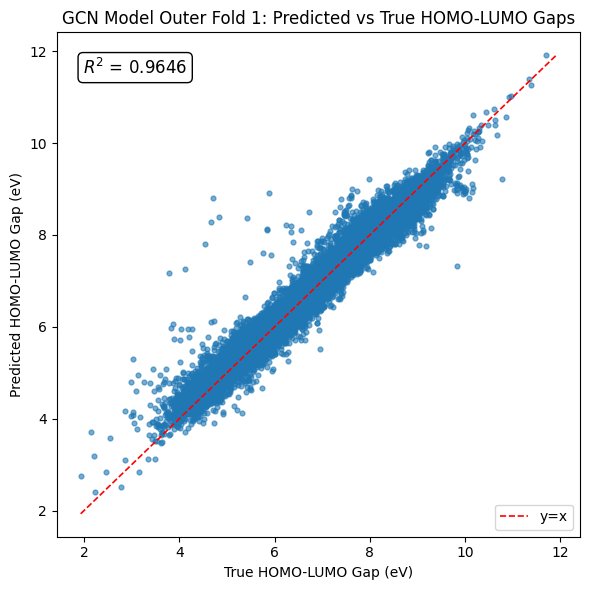

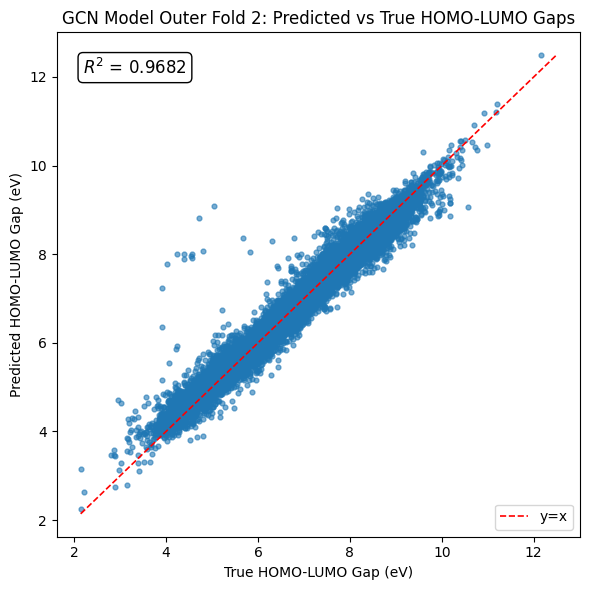

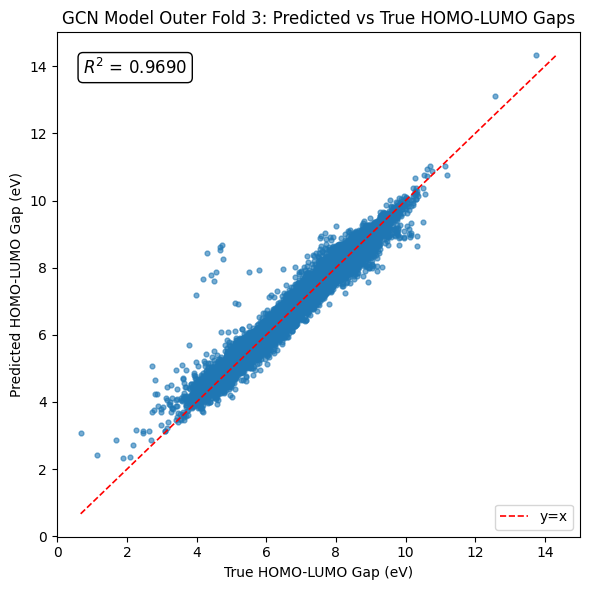

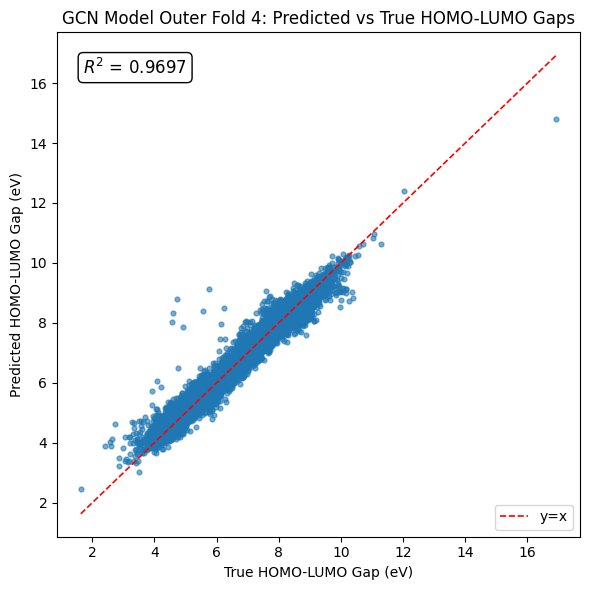

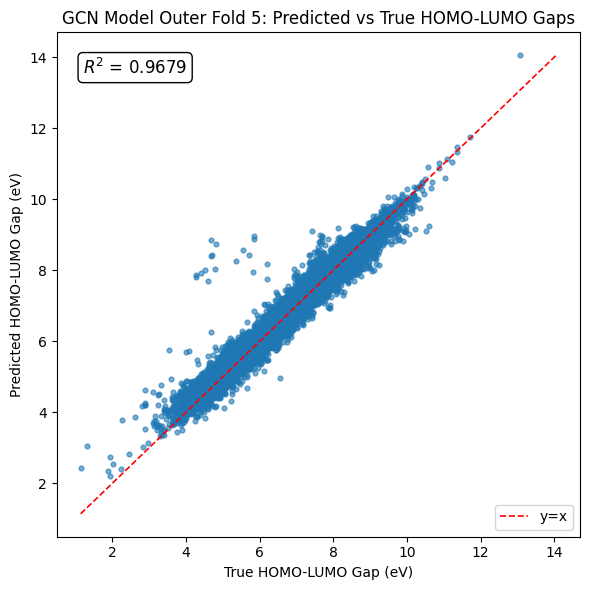

In [11]:
for i in range(5):
    plot_pred_vs_true(targets_outer_folds[i],predictions_outer_folds[i],r2_outer_folds[i], i)